# Radial Metallicity Gradients in NIHAO and GALAH


This script traces the face on position and iron abundance [Fe/H] of some of the youngest stars in a NIHAO simulation. It also overlays them on top of the gas density. To do so, it reads in the lite files of galaxy simulations from NIHAO and then performs.  

*How much does this picture deviate from a simple toy model of a linear Radius-[Fe/H] gradient and what can we learn about the real Milky Way?*


#### Github Repository

https://www.github.com/svenbuder/nihao_radial_metallicity_gradients

#### Author:
Sven Buder (ANU, sven.buder@anu.edu.au)

#### GALAH DR3:
Buder et al. (2021): https://ui.adsabs.harvard.edu/abs/2021MNRAS.506..150B

#### Open Cluster Memberships:
Cantat-Gaudin et al. (2020): https://ui.adsabs.harvard.edu/abs/2020A&A...633A..99C

#### Initial Data - NIHAO-UHD simulations:  
Buck (2020): https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.5435B  
Buck et al. (2020b): https://ui.adsabs.harvard.edu/abs/2020MNRAS.491.3461B  
Buck et al. (2021): https://ui.adsabs.harvard.edu/abs/2021MNRAS.508.3365B  
Buck et al. (2023): https://ui.adsabs.harvard.edu/abs/2023MNRAS.523.1565B  
Buder, Mijnarends, and Buck (2024): https://ui.adsabs.harvard.edu/abs/2024arXiv240413835B  

#### Milky Way Spiral Arms and Young Stars:
Hawkins (2023): https://ui.adsabs.harvard.edu/abs/2023MNRAS.525.3318H  
Hackshaw et al. (2024): https://ui.adsabs.harvard.edu/abs/2024arXiv240518120H

In [212]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

# general packages
import numpy as np
from astropy.table import Table, join
import os
from sklearn.linear_model import LinearRegression
from scipy.stats import binned_statistic_2d

# astropy
import astropy.units as u
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

# matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rcParams
rcParams['axes.labelsize'] = 15
rcParams['legend.fontsize'] = 15
rcParams['figure.titlesize'] = 20

panels = [
    'a)','b)','c)',
    'd)','e)','f)',
    'g)','h)','i)',
    'j)','k)','l)',
    'm)','n)','o)',
    'q)','r)','s)',
    't)','u)','v)',
    'w)','x)','y)',
    'z)','aa)','ab)',
    'ac)','ad)','ae)'
]

# 2. Data

## 2.1 Observations

In [230]:
# GALAH DR3 (Buder et al., 2021)
galah_dr3_main     = Table.read('data/GALAH_DR3_main_allstar_v2.fits')
galah_dr3_dynamics = Table.read('data/GALAH_DR3_VAC_dynamics_v2.fits')
galah_dr3 = join(galah_dr3_main, galah_dr3_dynamics, keys='sobject_id',metadata_conflicts='silent')
galah_dr3 = galah_dr3[~galah_dr3['dr2_source_id'].mask]
galah_dr3['e_R_Rzphi'] = 0.5/1.645*(galah_dr3['R_Rzphi_95'] - galah_dr3['R_Rzphi_5']) # 5th-95th cover 2sigma * 1.645
galah_dr3['e_z_Rzphi'] = 0.5/1.645*(galah_dr3['z_Rzphi_95'] - galah_dr3['z_Rzphi_5']) # convert to 1 sigma
galah_dr3 = galah_dr3[(
    (galah_dr3['flag_sp'] == 0) &
    (galah_dr3['flag_fe_h'] == 0)
)]
galah_dr3 = galah_dr3[['dr2_source_id','fe_h','e_fe_h','R_Rzphi','e_R_Rzphi','z_Rzphi','e_z_Rzphi']]


In [231]:
# APOGEE DR17 (SDSS Collaboration et al., 2022)
apogee_dr17 = Table.read('data/allStar-dr17-synspec_rev1.fits',1)
apogee_dr17['dr2_source_id'] = apogee_dr17['GAIAEDR3_SOURCE_ID']
apogee_dr17 = apogee_dr17[(
    (apogee_dr17['ASPCAPFLAG'] == 0) &
    (apogee_dr17['FE_H_FLAG'] == 0)
)]
apogee_dr17 = apogee_dr17[['dr2_source_id','RA','GAIAEDR3_PMRA','DEC','GAIAEDR3_PMDEC','GAIAEDR3_R_MED_PHOTOGEO','VHELIO_AVG','FE_H','FE_H_ERR','FE_H_FLAG',]]
# rename some keywords
apogee_dr17.rename_column('FE_H','fe_h')
apogee_dr17.rename_column('FE_H_ERR','e_fe_h')

In [232]:
# Cantat-Gaudin et al. (2020) Open Cluster Membership Catalogue
cg20 = Table.read('data/CantatGaudin_2020_AandA_640_1.fits')
cg20['dr2_source_id'] = cg20['GaiaDR2']
cg20 = cg20[~cg20['logAge'].mask]

In [233]:
# Open Cluster Members in GALAH DR3
oc_galah_dr3 = join(cg20, galah_dr3, keys = 'dr2_source_id')

# Open Cluster Members in GALAH DR3
oc_apogee_dr17 = join(cg20, apogee_dr17, keys = 'dr2_source_id')

In [239]:
unique_oc_galah_dr3, unique_oc_galah_dr3_index = np.unique(oc_galah_dr3['Cluster'], return_index=True)

oc_galah_dr3_unique = Table()
oc_galah_dr3_unique['Cluster'] = unique_oc_galah_dr3
oc_galah_dr3_unique['Age_Myr'] = 10**(oc_galah_dr3['logAge'][unique_oc_galah_dr3_index]-6)

for key_index, key in enumerate(['R_Rzphi','z_Rzphi','fe_h']):
    
    values_median = []
    values_scatter = []
    values_numbers = []
    
    for cluster in unique_oc_galah_dr3:
        
        in_cluster_unflagged = (
            (oc_galah_dr3['Cluster'] == cluster)
        )
        
        if len(oc_galah_dr3[key][in_cluster_unflagged]) > 3:
            values_median.append(np.median(oc_galah_dr3[key][in_cluster_unflagged]))
            values_scatter.append(
                np.std(oc_galah_dr3[key][in_cluster_unflagged])**2+
                np.median(oc_galah_dr3['e_'+key][in_cluster_unflagged])**2
            )
            if key_index == 0: values_numbers.append(len(oc_galah_dr3[key][in_cluster_unflagged]))
            
        else:
            values_median.append(np.nan)
            values_scatter.append(np.nan)
            if key_index == 0: values_numbers.append(0)
            
    if key_index == 0: oc_galah_dr3_unique['numbers'] = np.array(values_numbers,dtype=int)
    oc_galah_dr3_unique[key+'_median'] = np.array(values_median,dtype=np.float32)
    oc_galah_dr3_unique[key+'_scatter'] = np.array(values_scatter,dtype=np.float32)

oc_galah_dr3_unique = oc_galah_dr3_unique[np.isfinite(oc_galah_dr3_unique['R_Rzphi_median'])]
oc_galah_dr3_unique.sort('z_Rzphi_median')
oc_galah_dr3_unique[oc_galah_dr3_unique['Age_Myr'] < 1000]

/Users/buder/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)



Cluster,Age_Myr,numbers,R_Rzphi_median,R_Rzphi_scatter,z_Rzphi_median,z_Rzphi_scatter,fe_h_median,fe_h_scatter
bytes17,float32,int64,float32,float32,float32,float32,float32,float32
Blanco_1,104.71297,42,8.168409,2.6280757e-06,-0.20497741,1.1908915e-05,-0.05085206,0.009485066
NGC_1901,891.25055,17,8.16489,8.135366e-06,-0.20374805,5.6844215e-06,-0.28130436,0.26408595
Mamajek_4,371.53497,11,7.802387,5.5226457e-05,-0.10748461,4.271473e-06,0.027851105,0.029473562
Gulliver_6,16.595861,8,8.566823,7.9937956e-05,-0.1061165,4.9537033e-05,-0.0885005,0.05706812
NGC_1750,257.0395,6,8.902722,0.0060769543,-0.104843974,0.00038714288,-0.46351242,0.22405753
Alessi_24,72.44362,10,7.819755,4.5883597e-05,-0.09713226,5.235078e-06,-0.09848428,0.04785041
NGC_2516,239.88336,35,8.19405,2.6057191e-06,-0.08690442,6.1785504e-06,-0.08364582,0.13212267
ASCC_16,13.489633,4,8.5124655,1.6657345e-05,-0.08308483,4.297794e-06,-0.2516408,0.06747595
Ruprecht_145,812.8302,9,7.6544566,0.00034361333,-0.060565505,1.3870295e-05,-0.35698843,0.077702954


In [235]:
# First we need to calculate R, phi, and Z from APOGEE ra, dec, and D.

# galpy
import galpy
#from galpy.potential import MWPotential2014 as pot
from galpy.potential.mwpotentials import McMillan17 as pot
from galpy.actionAngle import actionAngleStaeckel, actionAngleSpherical
from galpy.orbit import Orbit

# Reference values
#r_galactic_centre = 8.178*u.kpc # Gravity Collaboration, 2019, A&A, 625, 10
r_galactic_centre = 8.21*u.kpc # McMillan Potential, 2017
z_galactic_plane = 25.0*u.pc # Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529

print('Reference frame:')
print('R_GC = '+str(r_galactic_centre)+' (McMillan, 2017, MNRAS, 465, 76)')
print('phi_GC = '+str(0*u.rad))
print('z_GC = '+str(z_galactic_plane)+' (Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529)')

v_total_sun = (np.tan(6.379*u.mas)*r_galactic_centre/u.yr).to(u.km/u.s) # pm_l by Reid & Brunthaler 2004, ApJ, 616, 872
print('V_total_sun: = '+"{:.2f}".format(v_total_sun)+' (Reid & Brunthaler 2004, ApJ, 616, 872)')
v_peculiar = [11.1, 15.17, 7.25]*u.km/u.s # U and W from Schoenrich, Binney, Dehnen, 2010, MNRAS, 403, 1829, V so that V = V_total-V_sun
print('V_peculiar = ',(v_peculiar),' (U and W from Schoenrich, Binney, Dehnen, 2010, MNRAS, 403, 1829)')
print('V-component of V_peculiar = 15.17 km/s, instead of 12.24 km/s by Schoenrich et al. (2010), for matching v_circular')
v_circular = np.round(v_total_sun-v_peculiar[1],1)
print('V_circular = ',"{:.2f}".format(v_circular),' (McMillan, 2017, MNRAS, 465, 76)')


Reference frame:
R_GC = 8.21 kpc (McMillan, 2017, MNRAS, 465, 76)
phi_GC = 0.0 rad
z_GC = 25.0 pc (Bland-Hawthorn & Gerhard, 2016, ARA&A, 54, 529)
V_total_sun: = 248.27 km / s (Reid & Brunthaler 2004, ApJ, 616, 872)
V_peculiar =  [11.1  15.17  7.25] km / s  (U and W from Schoenrich, Binney, Dehnen, 2010, MNRAS, 403, 1829)
V-component of V_peculiar = 15.17 km/s, instead of 12.24 km/s by Schoenrich et al. (2010), for matching v_circular
V_circular =  233.10 km / s  (McMillan, 2017, MNRAS, 465, 76)


In [241]:
ra     = list(oc_apogee_dr17['RA']) * u.deg
dec    = list(oc_apogee_dr17['DEC']) * u.deg
dist   = list(oc_apogee_dr17['r_med']) * u.pc
pm_ra  = list(oc_apogee_dr17['GAIAEDR3_PMRA']) * u.mas/u.yr
pm_dec = list(oc_apogee_dr17['GAIAEDR3_PMDEC']) * u.mas/u.yr
v_los  = list(oc_apogee_dr17['VHELIO_AVG']) * u.km/u.s

o = Orbit(
        vxvv=[ra,dec,dist,pm_ra, pm_dec,v_los],
        ro=r_galactic_centre,
        vo=v_circular,
        zo=z_galactic_plane,
        solarmotion=[-11.1, 15.17, 7.25]*u.km/u.s,
        radec=True
    )

oc_apogee_dr17['R_Rzphi'] = o.R()*u.kpc
oc_apogee_dr17['z_Rzphi'] = o.z()*u.kpc
oc_apogee_dr17['e_R_Rzphi'] = 0.00 * np.ones(len(oc_apogee_dr17['R_Rzphi']))
oc_apogee_dr17['e_z_Rzphi'] = 0.00 * np.ones(len(oc_apogee_dr17['R_Rzphi']))

unique_oc_apogee_dr17, unique_oc_apogee_dr17_index = np.unique(oc_apogee_dr17['Cluster'], return_index=True)

oc_apogee_dr17_unique = Table()
oc_apogee_dr17_unique['Cluster'] = unique_oc_apogee_dr17
oc_apogee_dr17_unique['Age_Myr'] = 10**(oc_apogee_dr17['logAge'][unique_oc_apogee_dr17_index]-6)

for key_index, key in enumerate(['R_Rzphi','z_Rzphi','fe_h']):
    
    values_median = []
    values_scatter = []
    values_numbers = []
    
    for cluster in unique_oc_apogee_dr17:
        
        in_cluster_unflagged = (
            (oc_apogee_dr17['Cluster'] == cluster)
        )
        
        if len(oc_apogee_dr17[key][in_cluster_unflagged]) > 3:
            values_median.append(np.median(oc_apogee_dr17[key][in_cluster_unflagged]))
            values_scatter.append(
                np.std(oc_apogee_dr17[key][in_cluster_unflagged])**2+
                np.median(oc_apogee_dr17['e_'+key][in_cluster_unflagged])**2
            )
            if key_index == 0: values_numbers.append(len(oc_apogee_dr17[key][in_cluster_unflagged]))
            
        else:
            values_median.append(np.nan)
            values_scatter.append(np.nan)
            if key_index == 0: values_numbers.append(0)
            
    if key_index == 0: oc_apogee_dr17_unique['numbers'] = np.array(values_numbers,dtype=int)
    oc_apogee_dr17_unique[key+'_median'] = np.array(values_median,dtype=np.float32)
    oc_apogee_dr17_unique[key+'_scatter'] = np.array(values_scatter,dtype=np.float32)

oc_apogee_dr17_unique = oc_apogee_dr17_unique[np.isfinite(oc_apogee_dr17_unique['R_Rzphi_median'])]
oc_apogee_dr17_unique.sort('z_Rzphi_median')
oc_apogee_dr17_unique[oc_apogee_dr17_unique['Age_Myr'] < 1000]

Cluster,Age_Myr,numbers,R_Rzphi_median,R_Rzphi_scatter,z_Rzphi_median,z_Rzphi_scatter,fe_h_median,fe_h_scatter
bytes17,float32,int64,float32,float32,float32,float32,float32,float32
Berkeley_2,588.8443,6,13.101703,6.869077e-07,-0.24535495,3.339771e-06,-0.21298,0.0005733819
NGC_1901,891.25055,5,8.162259,4.420749e-06,-0.21458678,1.0034699e-05,-0.21859,0.004542515
NGC_6705,309.0294,10,6.335927,4.6259245e-07,-0.08787831,1.2105428e-06,0.081313,0.0018383596
Melotte_22,77.62469,25,8.324222,4.0064808e-07,-0.026296005,1.8328576e-06,0.020439,0.00078101276
Melotte_20,51.286144,8,8.353687,5.9083015e-07,0.006783447,3.0663332e-06,-0.0185165,0.0024515514
Melotte_25,794.3275,7,8.253539,4.7380968e-07,0.0088025145,4.804974e-06,0.15225,0.0005556694
BH_56,17.782795,4,8.336555,6.6925077e-06,0.04729991,2.23839e-06,-0.0396945,0.005112523
NGC_2168,147.91086,27,9.1098175,6.01774e-08,0.06344674,5.8671653e-06,-0.041328,0.0012898582
Teutsch_51,676.0829,6,12.879281,3.4015242e-09,0.07829183,1.6546238e-06,-0.3377,0.00065623084


## 2.2 NIHAO simulations

In [265]:
sim_stars = Table.read('data/NIHAO_g8.26e11_extensive_stars.fits')
sim_gas   = Table.read('data/NIHAO_g8.26e11_extensive_gas.fits')

sim_stars['R'] = np.sqrt(sim_stars['x']**2 + sim_stars['y']**2)
sim_gas['R'] = np.sqrt(sim_gas['x']**2 + sim_gas['y']**2)

# Adjust [Fe/H] to be solar for 4.5+-0.5Gyr and R=8.2+-0.2kpc
sim_solar_type = (
    (np.abs(sim_stars['R'] - 8.21) < 0.5) &
    (np.abs(sim_stars['age'] - 4.5) < 0.5)
)
for key in sim_stars.keys():
    if key[-2:] == '_H':
        sim_stars[key] -= np.median(sim_stars[key][sim_solar_type])

# 3 Radius Metallicity Gradients

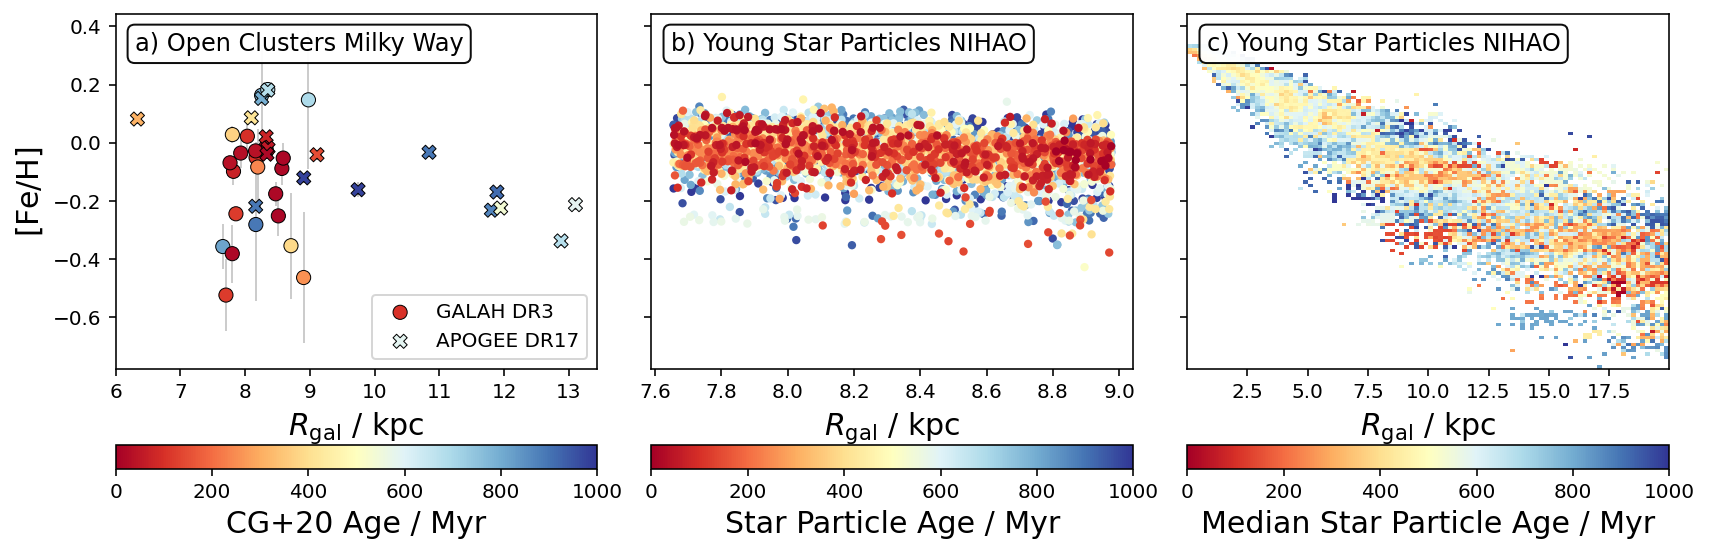

In [279]:
def plot_radius_metallicity_gradient(maximum_age_myr = 1000, z_max_pc = 2000):

    f, gs = plt.subplots(1,3,figsize=(12,4),sharey=True)

    ax = gs[0]
    ax.text(0.04,0.95,panels[0]+' Open Clusters Milky Way',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{gal}~/~\mathrm{kpc}$')
    ax.set_ylabel(r'$\mathrm{[Fe/H]}$')

    galah_subset = (
        (oc_galah_dr3_unique['Age_Myr'] < maximum_age_myr) &
        (np.abs(oc_galah_dr3_unique['z_Rzphi_median']) < z_max_pc / 1000.)
    )

    ax.errorbar(
        oc_galah_dr3_unique['R_Rzphi_median'][galah_subset],
        oc_galah_dr3_unique['fe_h_median'][galah_subset],
        yerr = oc_galah_dr3_unique['fe_h_scatter'][galah_subset],
        c = 'k', fmt = '.', lw = 0.2,
        zorder = 1
    )
    
    s = ax.scatter(
        oc_galah_dr3_unique['R_Rzphi_median'][galah_subset],
        oc_galah_dr3_unique['fe_h_median'][galah_subset],
        c = oc_galah_dr3_unique['Age_Myr'][galah_subset],
        s = 50, vmin = 0, vmax = maximum_age_myr, lw=0.5, edgecolor='k',
        zorder = 2, label = 'GALAH DR3', cmap='RdYlBu'
    )
    
    apogee_subset = (
        (oc_apogee_dr17_unique['Age_Myr'] < maximum_age_myr) &
        (np.abs(oc_apogee_dr17_unique['z_Rzphi_median']) < z_max_pc / 1000.)
    )

    ax.errorbar(
        oc_apogee_dr17_unique['R_Rzphi_median'][apogee_subset],
        oc_apogee_dr17_unique['fe_h_median'][apogee_subset],
        yerr = oc_apogee_dr17_unique['fe_h_scatter'][apogee_subset],
        c = 'k', fmt = '.', lw = 0.2,
        zorder = 1
    )
    
    s = ax.scatter(
        oc_apogee_dr17_unique['R_Rzphi_median'][apogee_subset],
        oc_apogee_dr17_unique['fe_h_median'][apogee_subset],
        c = oc_apogee_dr17_unique['Age_Myr'][apogee_subset],
        marker = 'X', s = 50, vmin = 0, vmax = maximum_age_myr, lw=0.5, edgecolor='k',
        zorder = 2, label = 'APOGEE DR17', cmap='RdYlBu'
    )
    ax.legend(fontsize=10,loc='lower right')
    plt.colorbar(s, ax=ax, label='CG+20 Age / Myr', orientation='horizontal')
    
    ax = gs[1]
    ax.text(0.04,0.95,panels[1]+' Young Star Particles NIHAO',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{gal}~/~\mathrm{kpc}$')
    #ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    #ax.yaxis.set_tick_params(labelleft=True)

    young_star_particles = (
        (sim_stars['age'] < maximum_age_myr/1000.) &
        (sim_stars['R'] > np.min(oc_galah_dr3_unique['R_Rzphi_median'][galah_subset])) &
        (sim_stars['R'] < np.max(oc_galah_dr3_unique['R_Rzphi_median'][galah_subset])) &
        (np.abs(sim_stars['z']) < np.max(z_max_pc / 1000.))
    )
    
    s = ax.scatter(
        sim_stars['R'][young_star_particles],
        sim_stars['Fe_H'][young_star_particles],
        c = sim_stars['age'][young_star_particles] * 1000.,
        s = 10, vmin = 0, vmax = maximum_age_myr, cmap='RdYlBu',
        zorder = 1
    )
    plt.colorbar(s, ax=ax, label='Star Particle Age / Myr', orientation='horizontal')


    ax = gs[2]
    ax.text(0.04,0.95,panels[2]+' Young Star Particles NIHAO',fontsize=12,transform=ax.transAxes,va='top',ha='left',bbox=dict(boxstyle='round', facecolor='w', alpha=0.95))
    ax.set_xlabel(r'$R_\mathrm{gal}~/~\mathrm{kpc}$')
    #ax.set_ylabel(r'$\mathrm{[Fe/H]}$')
    #ax.yaxis.set_tick_params(labelleft=True)

    young_star_particles = (
        (sim_stars['age'] < maximum_age_myr/1000.) &
        (sim_stars['R'] < 20.) &
        (sim_stars['z'] < 0.1)
    )

    stats, x_edge, y_edge, _ = binned_statistic_2d(
        sim_stars['R'][young_star_particles], 
        sim_stars['Fe_H'][young_star_particles],
        sim_stars['age'][young_star_particles]*1000, statistic='median',
        bins=100)
    pcm = ax.pcolormesh(x_edge, y_edge, stats.T, shading='auto', cmap='RdYlBu', vmin = 0, vmax = maximum_age_myr,)
    plt.colorbar(pcm, ax=ax, label='Median Star Particle Age / Myr', orientation='horizontal')

    plt.tight_layout()
    plt.show()
    plt.close()
    
plot_radius_metallicity_gradient()